import libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import datetime as dt
from datetime import datetime
import time
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
start_date = datetime(2017,4,1).date()
end_date = datetime(2022,4,30).date()
start_date_test = datetime(2022,5,1).date()
end_date_test = datetime(2022,5,30).date()
print(start_date)

2017-04-01


In [3]:
# fetch stock data
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAL&outputsize=full&datatype=json&apikey=I0D6SD0JRFHWY0JN"
api_response = requests.get(url)

js=api_response.json()
js_info, header = api_response.json()
#Convert to pandas dataframe
print(type(js[header]))
df = pd.DataFrame.from_dict(js[header], orient='index', dtype=np.float)

df.index = df.index.map(lambda x: datetime.strptime(x, "%Y-%m-%d"))

# 生成完整的日期序列
pdates = pd.date_range(start=start_date-dt.timedelta(days = 5), end=end_date_test+dt.timedelta(days = 5))
pdates
df = df.reindex(pdates, fill_value=np.nan)


df.to_csv('stock_dataset.csv', index=True, header=True, index_label='datetime')

df = pd.read_csv('stock_dataset.csv')
df = df.drop(columns=['1. open','2. high','3. low', '5. volume'])
df.columns=['datetime','stock']
df = df.set_index('datetime')
df.index = df.index.map(lambda x: datetime.strptime(x, "%Y-%m-%d"))

df.columns
df = df.loc[start_date:end_date_test,:]

df

<class 'dict'>


D:\anaconda3\envs\daps\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == "__main__":


,stock
datetime,
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,42.45
2017-04-04,40.90
2017-04-05,41.31
...,...
2022-05-26,17.24
2022-05-27,18.13
2022-05-28,NaN


In [4]:
# interpolation
# df_ = df.interpolate(method='linear',limit_direction='both',axis=0)
# df_.tail(20)
arr = df.to_numpy()
arr.shape


(1886, 1)

1886 1885


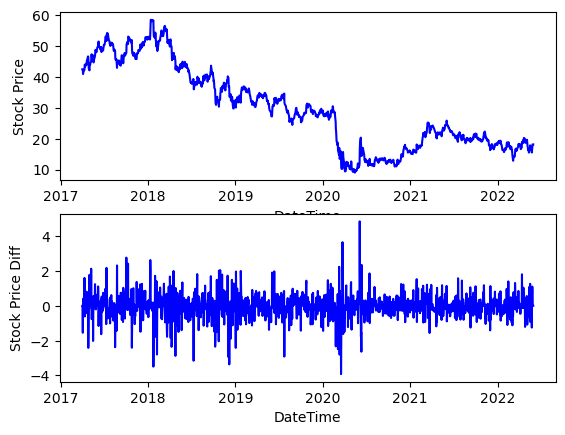

,stock
datetime,
2017-04-01,42.45
2017-04-02,42.45
2017-04-03,42.45
2017-04-04,40.90
2017-04-05,41.31
...,...
2022-05-26,17.24
2022-05-27,18.13
2022-05-28,18.13


In [5]:
def interpolate_plot(df, title):
    #线性插值让图变连续
    df_i = df.interpolate(method='linear',limit_direction='both',axis=0)

    plt.subplot(2,1,1)
    plt.plot(df_i, linestyle='-', marker='',  c='b')

    plt.xlabel('DateTime')
    plt.ylabel(title)

    plt.subplot(2,1,2)
    print(len(df_i.index.tolist()), len(np.diff(df_i.values.flatten())))
    plt.plot(df_i.index.tolist()[1:], np.diff(df_i.values.flatten()), linestyle='-', marker='',  c='b')

    plt.xlabel('DateTime')
    plt.ylabel(title + ' Diff')

    plt.show()
    
    return df_i

interpolate_plot(df,'Stock Price')


properties of stock price: 9.04 58.47 28.26 29.561216320246345 173.99225294704695
properties of stock price daily difference: -3.9299999999999997 4.869999999999999 -0.029999999999997584 -0.01873651771956857 0.672142586971541


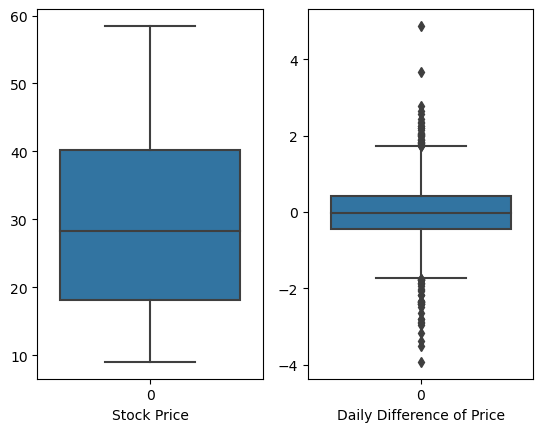

In [6]:
def date_preprocess(df):
    df = df.dropna(axis=0, how='any') #delete all the rows who has NaN
    df_value = df.values.flatten()
    df_value = df_value[np.logical_not(np.isnan(df_value))] #delete nan values
    df_date = df.index.values
    print('properties of stock price:', df_value.min(),df_value.max(),np.median(df_value),df_value.mean(),df_value.var())
    df_diff = np.diff(df_value)
    print('properties of stock price daily difference:', df_diff.min(),df_diff.max(),np.median(df_diff),df_diff.mean(),df_diff.var())
    df_date_diff = df_date[1:]
    
    return df_value, df_date, df_diff, df_date_diff

def box_plot(df_value, df_diff, title_1 ,title_2):
    # box plot
    plt.subplot(1,2,1)
    sns.boxplot(df_value)
    plt.xlabel(title_1)
    plt.subplot(1,2,2)
    sns.boxplot(df_diff)
    plt.xlabel(title_2)
    plt.show()

df_value, df_date, df_diff, df_date_diff = date_preprocess(df)
box_plot(df_value, df_diff, r'Stock Price', r'Daily Difference of Price')

In [7]:
def z_plot(df_diff, df_date_diff):
    # calculate the absolute value of z-score
    z = np.abs(stats.zscore(df_diff))

    print('z score of the dataset is:\r\n',z)

    plt.plot(df_date_diff,z)
    plt.grid()
    plt.ylim([0, 6])
    plt.ylabel('Z score')
    plt.show()
    
    return z

def z_out(z, df_diff, df_date_diff, threshold = 4):
    # set a threshold and find the location where the value meets our condition(s)
    outlier_loc = np.where(z > threshold)

    # find the outlier value given its index
    outlier_by_Z_Score = df_diff[outlier_loc]
    print('the data classified as outlier by z score:\r\n', outlier_by_Z_Score)
    print('the year of the outlier is:\r\n', df_date_diff[outlier_loc])
    
    return outlier_by_Z_Score, df_date_diff[outlier_loc]

z score of the dataset is:
 [0.97711792 0.85961011 0.89069282 ... 1.01824055 0.93408979 0.86661757]


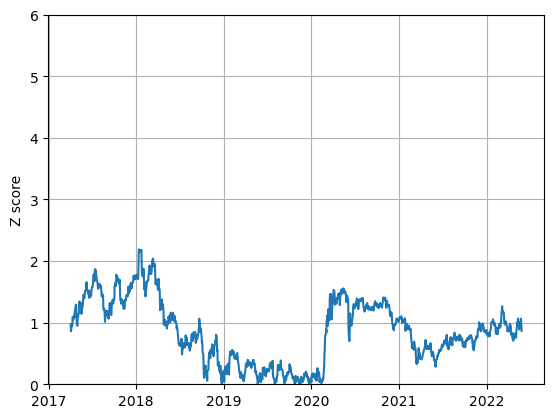

the data classified as outlier by z score:
 [56.42 58.47 57.98 58.16 58.34 58.06 58.1  58.29 56.07 56.5  56.23]
the year of the outlier is:
 ['2018-01-11T00:00:00.000000000' '2018-01-12T00:00:00.000000000'
 '2018-01-16T00:00:00.000000000' '2018-01-17T00:00:00.000000000'
 '2018-01-18T00:00:00.000000000' '2018-01-19T00:00:00.000000000'
 '2018-01-22T00:00:00.000000000' '2018-01-23T00:00:00.000000000'
 '2018-03-09T00:00:00.000000000' '2018-03-12T00:00:00.000000000'
 '2018-03-13T00:00:00.000000000']


(array([56.42, 58.47, 57.98, 58.16, 58.34, 58.06, 58.1 , 58.29, 56.07,
        56.5 , 56.23]),
 array(['2018-01-11T00:00:00.000000000', '2018-01-12T00:00:00.000000000',
        '2018-01-16T00:00:00.000000000', '2018-01-17T00:00:00.000000000',
        '2018-01-18T00:00:00.000000000', '2018-01-19T00:00:00.000000000',
        '2018-01-22T00:00:00.000000000', '2018-01-23T00:00:00.000000000',
        '2018-03-09T00:00:00.000000000', '2018-03-12T00:00:00.000000000',
        '2018-03-13T00:00:00.000000000'], dtype='datetime64[ns]'))

In [8]:
df_z = z_plot(df_value, df_date)
z_out(df_z, df_value, df_date, threshold = 2)

z score of the dataset is:
 [1.86775204 0.52294952 0.52294952 ... 0.79129357 1.37677151 1.10842745]


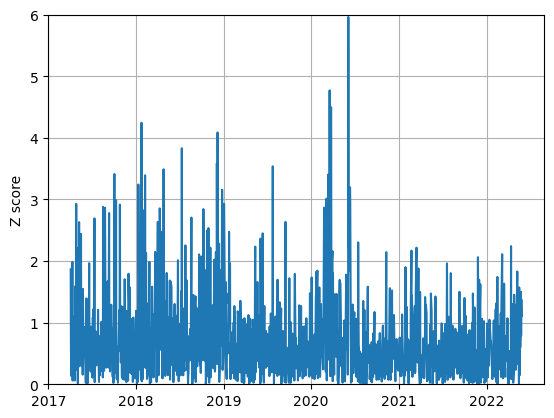

the data classified as outlier by z score:
 [-3.5  -3.37 -3.93  3.67  4.87]
the year of the outlier is:
 ['2018-01-24T00:00:00.000000000' '2018-12-07T00:00:00.000000000'
 '2020-03-18T00:00:00.000000000' '2020-03-24T00:00:00.000000000'
 '2020-06-04T00:00:00.000000000']


(array([-3.5 , -3.37, -3.93,  3.67,  4.87]),
 array(['2018-01-24T00:00:00.000000000', '2018-12-07T00:00:00.000000000',
        '2020-03-18T00:00:00.000000000', '2020-03-24T00:00:00.000000000',
        '2020-06-04T00:00:00.000000000'], dtype='datetime64[ns]'))

In [9]:
df_diff_z = z_plot(df_diff, df_date_diff)
z_out(df_diff_z, df_diff, df_date_diff)

In [10]:
def skew_kurt(R):
    R_mean = np.mean(R) #计算均值
    R_var = np.var(R)  #计算方差
    R_sc = np.mean((R - R_mean) ** 3)  #计算偏斜度
    R_ku = np.mean((R - R_mean) ** 4) / pow(R_var, 2) #计算峰度
    return R_mean, R_var, R_sc, R_ku
print('mean var sc ku')
print(skew_kurt(df_value))
print(skew_kurt(df_diff))

mean var sc ku
(29.561216320246345, 173.99225294704695, 810.5148209601173, 1.9152473896711542)
(-0.01873651771956857, 0.672142586971541, -0.05002799086746961, 5.941287450718906)


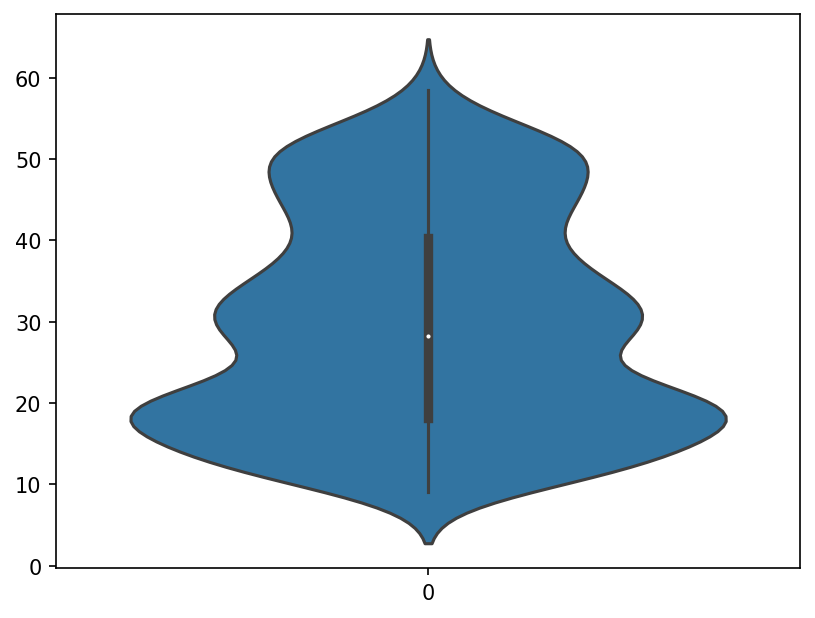

In [11]:
plt.figure(dpi=150)
sns.violinplot(df_value)
plt.show()

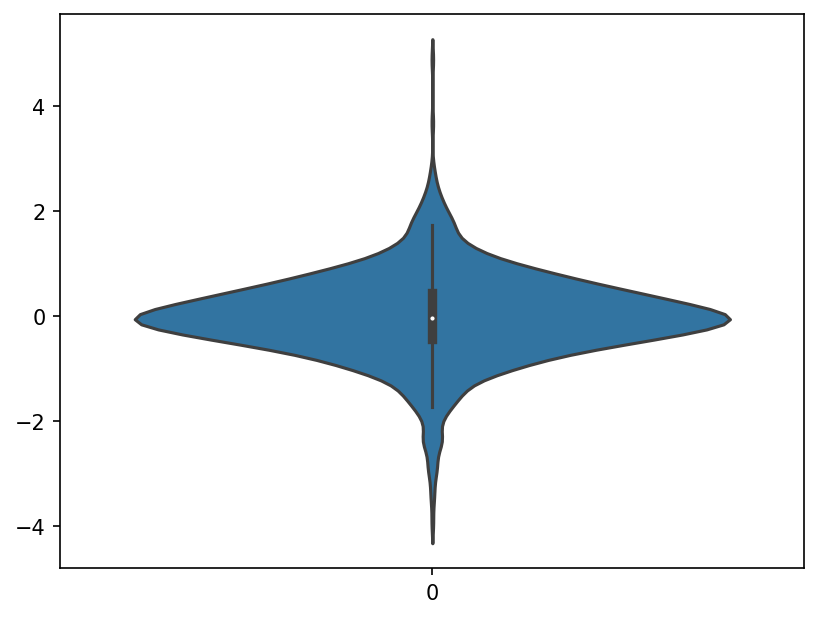

In [12]:
plt.figure(dpi=150)
sns.violinplot(df_diff)
plt.show()

D:\anaconda3\envs\daps\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


<AxesSubplot:ylabel='Density'>

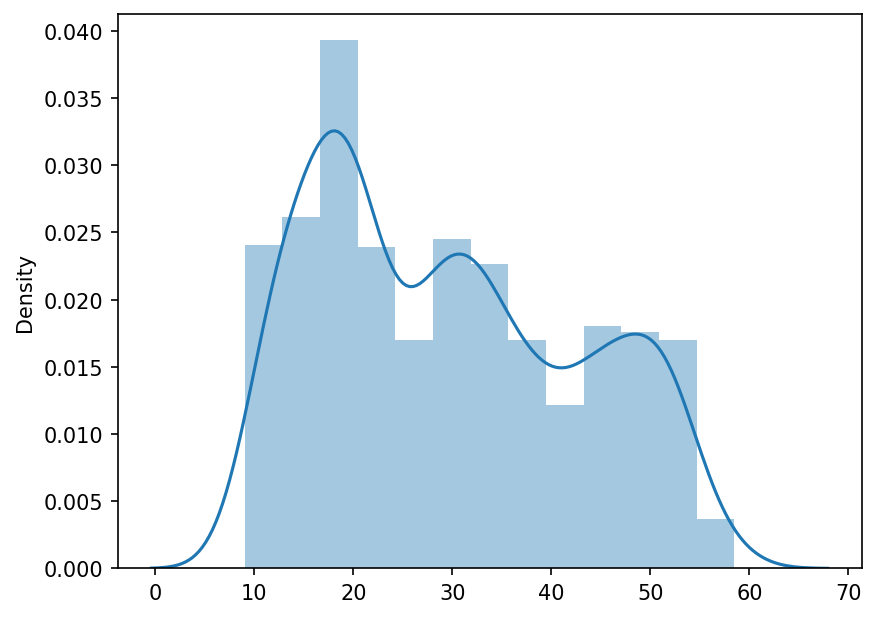

In [13]:
plt.figure(dpi=150)
sns.distplot(df_value)

D:\anaconda3\envs\daps\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


<AxesSubplot:ylabel='Density'>

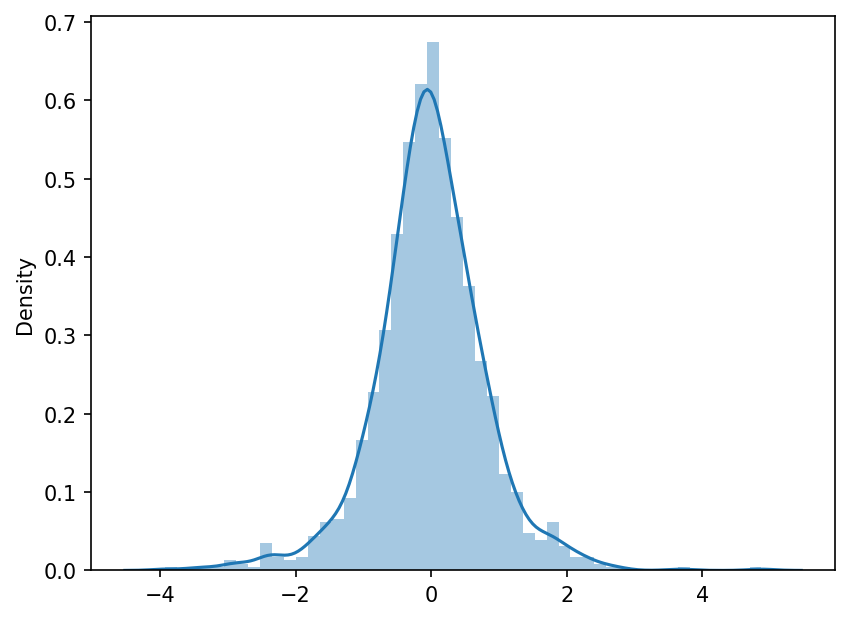

In [14]:
plt.figure(dpi=150)
sns.distplot(df_diff)

In [15]:
start = datetime(2017, 4, 1)
end = datetime(2022, 5, 31)

df_1 = pd.read_excel('EER_EPJK_PF4_RGC_DPGd.xls', sheet_name='Data 1', index_col=0, header = 2,skiprows= [0,1])
# df_1 = df.drop(df_1.index[[0, 1]])
df
df_1.columns = ['Jet Fuel Spot']
str(df.index)

df_1.index = pd.to_datetime(df_1.index)
df_1.index

pdates = pd.date_range(start=start, end=end)
pdates
df_1 = df_1.reindex(pdates, fill_value=np.nan)
df_1 = df_1.loc[start_date:end_date,:]
df_1

,Jet Fuel Spot
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,1.471
2017-04-04,1.510
2017-04-05,1.511
...,...
2022-04-26,4.520
2022-04-27,4.789
2022-04-28,5.066
2022-04-29,4.529


1856 1855


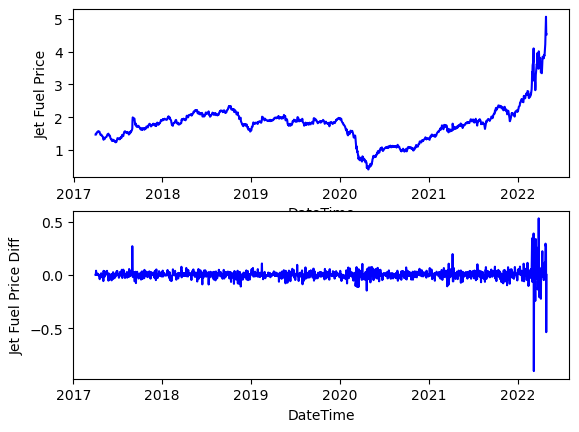

,Jet Fuel Spot
2017-04-01,1.471
2017-04-02,1.471
2017-04-03,1.471
2017-04-04,1.510
2017-04-05,1.511
...,...
2022-04-26,4.520
2022-04-27,4.789
2022-04-28,5.066
2022-04-29,4.529


In [16]:
interpolate_plot(df_1, 'Jet Fuel Price')

properties of stock price: 0.407 5.066 1.823 1.78674114870181 0.30778416194958524
properties of stock price daily difference: -0.9019999999999997 0.5300000000000002 0.002000000000000113 0.0024078740157480313 0.003697184819889639


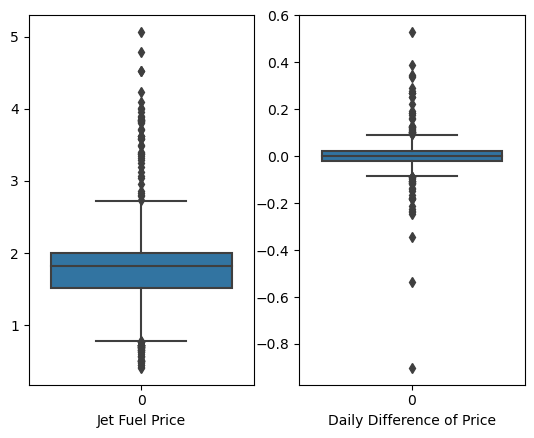

In [17]:
df_1_value, df_1_date, df_1_diff, df_1_date_diff = date_preprocess(df_1)
box_plot(df_1_value, df_1_diff, r'Jet Fuel Price', r'Daily Difference of Price')

z score of the dataset is:
 [0.60179983 0.02315412 0.23998439 ... 4.38441583 4.51598509 8.87118633]


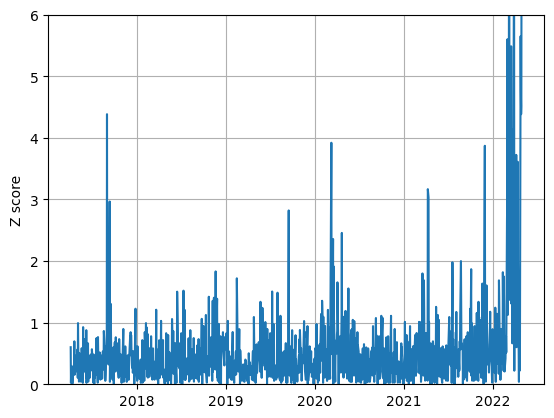

the data classified as outlier by z score:
 [ 0.343  0.388 -0.902  0.336 -0.344  0.53   0.346 -0.537]
the year of the outlier is:
 ['2022-03-02T00:00:00.000000000' '2022-03-08T00:00:00.000000000'
 '2022-03-09T00:00:00.000000000' '2022-03-17T00:00:00.000000000'
 '2022-03-28T00:00:00.000000000' '2022-03-29T00:00:00.000000000'
 '2022-04-25T00:00:00.000000000' '2022-04-29T00:00:00.000000000']


(array([ 0.343,  0.388, -0.902,  0.336, -0.344,  0.53 ,  0.346, -0.537]),
 array(['2022-03-02T00:00:00.000000000', '2022-03-08T00:00:00.000000000',
        '2022-03-09T00:00:00.000000000', '2022-03-17T00:00:00.000000000',
        '2022-03-28T00:00:00.000000000', '2022-03-29T00:00:00.000000000',
        '2022-04-25T00:00:00.000000000', '2022-04-29T00:00:00.000000000'],
       dtype='datetime64[ns]'))

In [18]:
df_1_diff_z = z_plot(df_1_diff, df_1_date_diff)
z_out(df_1_diff_z, df_1_diff, df_1_date_diff, 5)

In [19]:
# weather data
from meteostat import Point, Daily,  Stations

cities = {"New York": (40.730610, -73.935242), "Los Angeles": (34.052235, -118.243683),"Chicago": (41.875562, -87.624210), "Houston": (29.758938, -95.367697), "Phoenix": (33.448376, -112.074036), "Philadelphia": (39.952335, -75.163789), "San Antonio": (29.424349, -98.491142), "San Diego": (32.715329, -117.157255), "Dallas": (32.776664, -96.796988), "San Jose": (37.338208, -121.886329)}
coordinates = {'ATL':[33.63, -84.42], 'DFW':[32.89, -97.04], 'DEN':[39.85, -104.67], 'ORD':[41.97, -87.90], 'LAX':[33.94, -118.42], 'CLT':[35.21, -80.94], 'MCO':[28.41, -81.30], 'LAS':[36.08, -115.16], 'PHX':[33.43, -112.00], 'MIA':[25.79, -80.28]}

start = datetime(2017, 4, 1)
end = datetime(2022, 5, 31)

dataframe_list = []

def get_weather_data(coord, start_date, end_date):
    data = []
    city = Point(*coord)
    data = Daily(city, start_date, end_date)
    data = data.fetch()
    data = data.drop(columns = ['tmin', 'tmax', 'wdir', 'wpgt', 'pres', 'tsun'])
    return data

for i, coord in coordinates.items():
    print(i, coord)
    data = get_weather_data(coord, start, end)
    
    def rename_map(x):
        return i + '_' + x
    
    data = data.rename(columns=rename_map)
    dataframe_list.append(data)

df_2 = pd.concat(dataframe_list, axis = 1, join = 'outer')

pdates = pd.date_range(start=start, end=end)
pdates
df_2 = df_2.reindex(pdates, fill_value=np.nan)
df_2

ATL [33.63, -84.42]
DFW [32.89, -97.04]
DEN [39.85, -104.67]
ORD [41.97, -87.9]
LAX [33.94, -118.42]
CLT [35.21, -80.94]
MCO [28.41, -81.3]
LAS [36.08, -115.16]
PHX [33.43, -112.0]
MIA [25.79, -80.28]


,ATL_tavg,ATL_prcp,ATL_snow,ATL_wspd,DFW_tavg,DFW_prcp,DFW_snow,DFW_wspd,DEN_tavg,DEN_prcp,...,LAS_snow,LAS_wspd,PHX_tavg,PHX_prcp,PHX_snow,PHX_wspd,MIA_tavg,MIA_prcp,MIA_snow,MIA_wspd
2017-04-01,17.4,0.0,0.0,7.9,20.9,0.0,0.0,20.2,1.8,0.8,...,0.0,18.7,15.9,0.0,NaN,7.9,26.6,0.0,NaN,9.4
2017-04-02,18.8,0.0,0.0,12.6,19.3,54.4,0.0,21.6,6.1,0.0,...,0.0,6.8,18.8,0.0,NaN,11.9,26.7,0.0,NaN,13.3
2017-04-03,18.8,13.5,0.0,13.7,17.8,0.0,0.0,9.0,8.8,2.0,...,0.0,13.0,22.3,0.0,NaN,16.6,26.7,0.0,NaN,19.4
2017-04-04,20.9,0.0,0.0,13.7,22.4,0.0,0.0,24.5,3.0,5.1,...,0.0,9.4,20.9,0.0,NaN,12.2,26.9,0.0,NaN,16.9
2017-04-05,16.2,108.5,0.0,6.3,17.4,0.0,0.0,32.0,3.2,0.0,...,0.0,6.8,21.6,0.0,NaN,9.7,26.7,0.0,NaN,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27,22.2,0.8,0.0,11.2,25.0,0.0,0.0,7.1,21.6,0.0,...,0.0,18.4,34.1,0.0,0.0,11.5,28.2,0.0,0.0,15.8
2022-05-28,20.8,0.0,0.0,4.3,27.9,0.0,0.0,24.2,21.0,0.0,...,0.0,23.4,32.7,0.0,0.0,15.5,28.3,9.4,0.0,11.9
2022-05-29,23.6,0.0,0.0,5.6,28.7,0.0,0.0,32.6,17.9,2.8,...,0.0,27.0,30.8,0.0,0.0,15.5,25.3,10.4,0.0,9.4
2022-05-30,24.0,0.3,0.0,4.1,28.8,0.0,0.0,35.9,12.9,0.0,...,0.0,13.7,29.3,0.0,0.0,13.7,25.4,19.3,0.0,11.9


In [20]:
df_2.isnull().sum()


ATL_tavg      0
ATL_prcp      0
ATL_snow      0
ATL_wspd      0
DFW_tavg      0
DFW_prcp      0
DFW_snow      0
DFW_wspd      0
DEN_tavg      0
DEN_prcp      0
DEN_snow      0
DEN_wspd      0
ORD_tavg      0
ORD_prcp      0
ORD_snow      0
ORD_wspd      0
LAX_tavg      0
LAX_prcp      0
LAX_snow    552
LAX_wspd      0
CLT_tavg      0
CLT_prcp      0
CLT_snow      0
CLT_wspd      0
MCO_tavg      0
MCO_prcp      0
MCO_snow      0
MCO_wspd      0
LAS_tavg      0
LAS_prcp      0
LAS_snow      1
LAS_wspd      0
PHX_tavg      0
PHX_prcp      0
PHX_snow    384
PHX_wspd      0
MIA_tavg      0
MIA_prcp      0
MIA_snow    430
MIA_wspd      0
dtype: int64

In [21]:
df_2 = df_2.fillna(0)
df_2['ALL_tavg'] = df_2.iloc[:,0::4].sum(axis=1)
df_2['ALL_prcp'] = df_2.iloc[:,1::4].sum(axis=1)
df_2['ALL_snow'] = df_2.iloc[:,2::4].sum(axis=1)
df_2['ALL_wspd'] = df_2.iloc[:,3::4].sum(axis=1)
df_2

,ATL_tavg,ATL_prcp,ATL_snow,ATL_wspd,DFW_tavg,DFW_prcp,DFW_snow,DFW_wspd,DEN_tavg,DEN_prcp,...,PHX_snow,PHX_wspd,MIA_tavg,MIA_prcp,MIA_snow,MIA_wspd,ALL_tavg,ALL_prcp,ALL_snow,ALL_wspd
2017-04-01,17.4,0.0,0.0,7.9,20.9,0.0,0.0,20.2,1.8,0.8,...,0.0,7.9,26.6,0.0,0.0,9.4,166.0,0.8,0.0,118.2
2017-04-02,18.8,0.0,0.0,12.6,19.3,54.4,0.0,21.6,6.1,0.0,...,0.0,11.9,26.7,0.0,0.0,13.3,175.0,54.4,0.0,122.3
2017-04-03,18.8,13.5,0.0,13.7,17.8,0.0,0.0,9.0,8.8,2.0,...,0.0,16.6,26.7,0.0,0.0,19.4,184.7,37.8,0.0,151.7
2017-04-04,20.9,0.0,0.0,13.7,22.4,0.0,0.0,24.5,3.0,5.1,...,0.0,12.2,26.9,0.0,0.0,16.9,178.0,5.6,0.0,149.2
2017-04-05,16.2,108.5,0.0,6.3,17.4,0.0,0.0,32.0,3.2,0.0,...,0.0,9.7,26.7,0.0,0.0,13.7,170.1,161.1,0.0,149.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27,22.2,0.8,0.0,11.2,25.0,0.0,0.0,7.1,21.6,0.0,...,0.0,11.5,28.2,0.0,0.0,15.8,248.4,14.8,0.0,144.1
2022-05-28,20.8,0.0,0.0,4.3,27.9,0.0,0.0,24.2,21.0,0.0,...,0.0,15.5,28.3,9.4,0.0,11.9,244.9,9.4,0.0,137.4
2022-05-29,23.6,0.0,0.0,5.6,28.7,0.0,0.0,32.6,17.9,2.8,...,0.0,15.5,25.3,10.4,0.0,9.4,245.3,13.7,0.0,164.2
2022-05-30,24.0,0.3,0.0,4.1,28.8,0.0,0.0,35.9,12.9,0.0,...,0.0,13.7,25.4,19.3,0.0,11.9,241.6,19.6,0.0,161.1


In [22]:
# #covid data
# from covid19dh import covid19
# start = datetime(2017, 4, 1)
# end = datetime(2022, 5, 31)
# x, src = covid19("USA", start = start, end = end)
# x = x.set_index('date')
# x.index

# x = x[[ 'confirmed']]

# pdates = pd.date_range(start=start, end=end)
# pdates
# x = x.reindex(pdates, fill_value=0)

# x.to_csv('covid_dataset.csv', index=True, header=True, index_label='datetime')


In [23]:
df_3 = pd.read_csv('covid_dataset.csv')
# df = df.drop(columns=['1. open','2. high','3. low', '5. volume'])
df_3.columns=['datetime','confirmed']
df_3 = df_3.set_index('datetime')
df_3.index = df_3.index.map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df_3

,confirmed
datetime,
2017-04-01,0.0
2017-04-02,0.0
2017-04-03,0.0
2017-04-04,0.0
2017-04-05,0.0
...,...
2022-05-27,83903655.0
2022-05-28,83917417.0
2022-05-29,83926462.0


In [24]:
df_3['daily confirmed'] = np.insert(np.diff(df_3.values.flatten()), 0, 0)

In [ ]:

df_3['daily confirmed smoothed'] = df_3["daily confirmed"].rolling(window=7, center=True, min_periods=1).mean()

plt.subplot(2,1,1)
plt.plot(df_3.index.values,  df_3["daily confirmed"], linestyle='-', marker='',  c='b')
plt.xlabel('DateTime')
plt.ylabel('original daily cofirmed')

plt.subplot(2,1,2)
plt.plot(df_3.index.values,  df_3["daily confirmed smoothed"], linestyle='-', marker='',  c='b')
plt.xlabel('DateTime')
plt.ylabel('daily cofirmed after rolling')

plt.show()

df

Correlation calculation

In [26]:
# Unify the timeline of all data by concat


In [27]:
print( len(df_date), len(df_value), len(df_diff), len(df_1_diff), len(df_1_value),len(df_1_date))

1299 1299 1298 1270 1271 1271


In [53]:
# Unify the timeline of all data
tmp1 = pd.DataFrame(df_date, columns = ['datetime'])
tmp1['stock price'] = df_value
tmp1['stock price diff'] = np.insert(df_diff, 0, 0)
tmp1 = tmp1.set_index('datetime')
tmp1

tmp2 = pd.DataFrame(df_1_date, columns = ['datetime'])
tmp2['jet fuel price'] = df_1_value
tmp2['jet fuel price diff'] = np.insert(df_1_diff, 0, 0)
tmp2 = tmp2.set_index('datetime')
tmp2

tmp1 = tmp1.merge(tmp2, left_index=True, right_index=True, how = 'left')
tmp1 = tmp1.merge(df_2[['ALL_tavg','ALL_prcp','ALL_snow','ALL_wspd']],left_index=True, right_index=True, how = 'left')
tmp1 = tmp1.merge(df_3, left_index=True, right_index=True, how = 'left')
# new = pd.concat([tmp1,df_2[['ALL_tavg','ALL_prcp','ALL_snow','ALL_wspd']],df_3], axis=1, join='left')
tmp1.fillna(0, inplace=True)
tmp1

,stock price,stock price diff,jet fuel price,jet fuel price diff,ALL_tavg,ALL_prcp,ALL_snow,ALL_wspd,confirmed,daily confirmed,daily confirmed smoothed
datetime,,,,,,,,,,,
2017-04-03,42.45,0.00,1.471,0.000,184.7,37.8,0.0,151.7,0.0,0.0,0.000000
2017-04-04,40.90,-1.55,1.510,0.039,178.0,5.6,0.0,149.2,0.0,0.0,0.000000
2017-04-05,41.31,0.41,1.511,0.001,170.1,161.1,0.0,149.9,0.0,0.0,0.000000
2017-04-06,41.72,0.41,1.528,0.017,170.1,11.7,0.0,176.5,0.0,0.0,0.000000
2017-04-07,41.81,0.09,1.543,0.015,168.8,1.3,0.0,165.2,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,16.75,0.49,0.000,0.000,216.1,61.3,0.0,145.4,83320644.0,132884.0,110899.142857
2022-05-24,15.50,-1.25,0.000,0.000,216.6,38.0,0.0,140.2,83453009.0,132365.0,110741.285714
2022-05-25,16.13,0.63,0.000,0.000,221.3,19.8,0.0,151.0,83640103.0,187094.0,107377.714286


<AxesSubplot:>

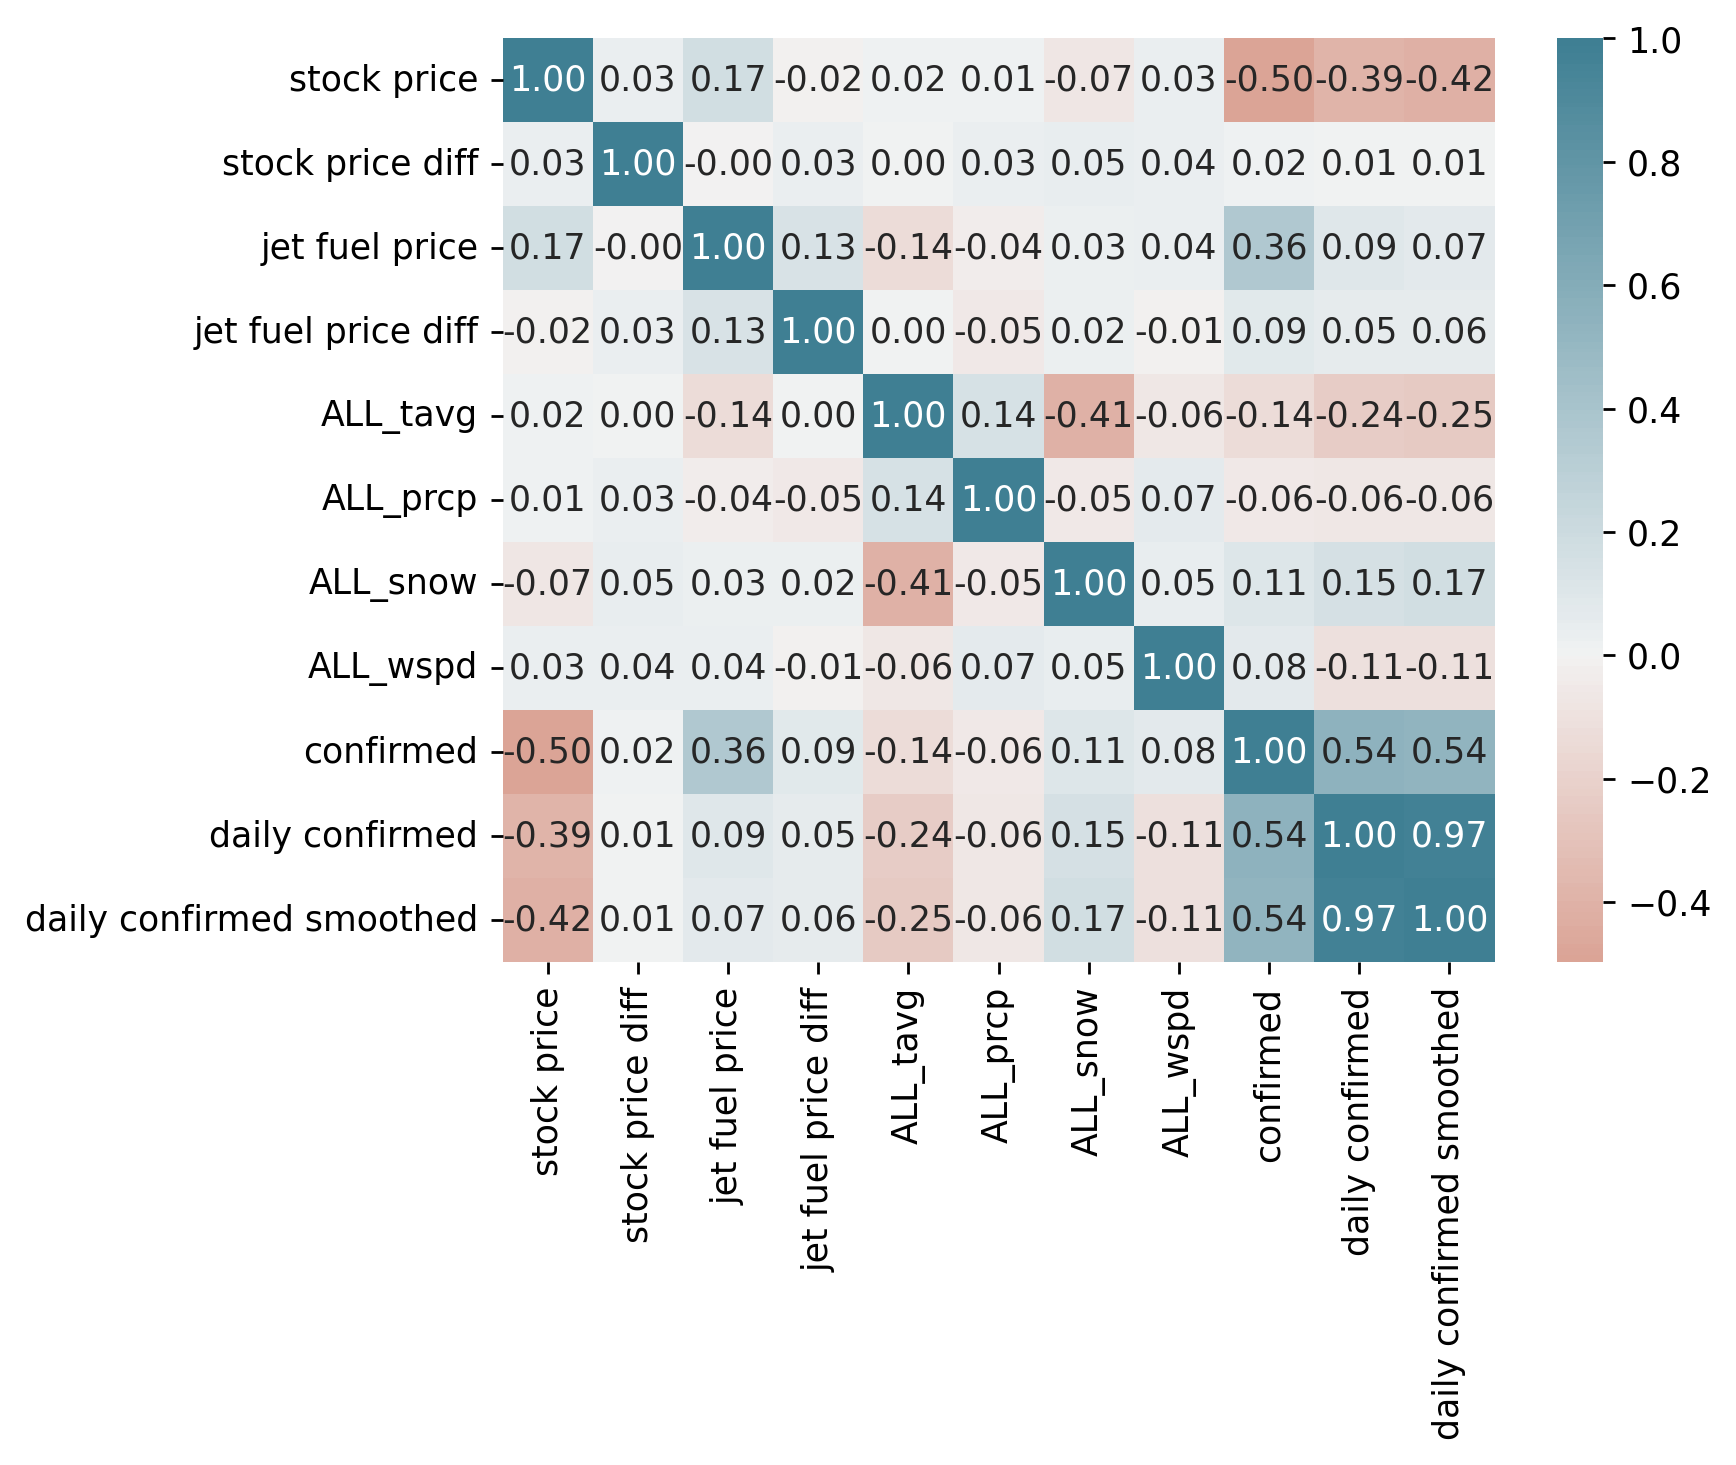

In [54]:
plt.figure(dpi=250)
sns.heatmap(tmp1.corr(), 
            cmap=sns.diverging_palette(20, 220, n=200), 
            annot=True, # 注入数据
            fmt='.2f',   # 字符串格式代码
            center = 0,  # 绘制有色数据时将色彩映射居中的值
           )


Normalization

In [51]:
tmp1_norm = (tmp1- tmp1.mean()) / (tmp1.std())
tmp1_norm

,stock price,stock price diff,jet fuel price,jet fuel price diff,ALL_tavg,ALL_prcp,ALL_snow,ALL_wspd,confirmed,daily confirmed,daily confirmed smoothed
datetime,,,,,,,,,,,
2017-04-03,0.976742,0.022836,-0.452811,-0.039127,-0.085043,0.517917,-0.308018,1.150069,-0.596960,-0.423776,-0.448648
2017-04-04,0.859279,-1.867769,-0.388792,0.609293,-0.184143,-0.630947,-0.308018,1.040891,-0.596960,-0.423776,-0.448648
2017-04-05,0.890350,0.522932,-0.387151,-0.022501,-0.300993,4.917140,-0.308018,1.071461,-0.596960,-0.423776,-0.448648
2017-04-06,0.921421,0.522932,-0.359245,0.243518,-0.300993,-0.413305,-0.308018,2.233111,-0.596960,-0.423776,-0.448648
2017-04-07,0.928241,0.132613,-0.334622,0.210265,-0.320221,-0.784367,-0.308018,1.739628,-0.596960,-0.423776,-0.448648
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,-0.970864,0.620511,-2.867485,-0.039127,0.379395,1.356374,-0.308018,0.874941,2.942304,0.657060,0.674457
2022-05-24,-1.065591,-1.501846,-2.867485,-0.039127,0.386791,0.525053,-0.308018,0.647851,2.947926,0.652839,0.672859
2022-05-25,-1.017849,0.791276,-2.867485,-0.039127,0.456309,-0.124305,-0.308018,1.119499,2.955874,1.097987,0.638795


In [57]:
tmp = tmp1.drop(columns=['jet fuel price diff','ALL_tavg','ALL_prcp','ALL_snow','ALL_wspd','daily confirmed'])
tmp

,stock price,stock price diff,jet fuel price,confirmed,daily confirmed smoothed
datetime,,,,,
2017-04-03,42.45,0.00,1.471,0.0,0.000000
2017-04-04,40.90,-1.55,1.510,0.0,0.000000
2017-04-05,41.31,0.41,1.511,0.0,0.000000
2017-04-06,41.72,0.41,1.528,0.0,0.000000
2017-04-07,41.81,0.09,1.543,0.0,0.000000
...,...,...,...,...,...
2022-05-23,16.75,0.49,0.000,83320644.0,110899.142857
2022-05-24,15.50,-1.25,0.000,83453009.0,110741.285714
2022-05-25,16.13,0.63,0.000,83640103.0,107377.714286


In [58]:
tmp_norm = (tmp- tmp.mean()) / (tmp.std())
tmp_norm

,stock price,stock price diff,jet fuel price,confirmed,daily confirmed smoothed
datetime,,,,,
2017-04-03,0.976742,0.022836,-0.452811,-0.596960,-0.448648
2017-04-04,0.859279,-1.867769,-0.388792,-0.596960,-0.448648
2017-04-05,0.890350,0.522932,-0.387151,-0.596960,-0.448648
2017-04-06,0.921421,0.522932,-0.359245,-0.596960,-0.448648
2017-04-07,0.928241,0.132613,-0.334622,-0.596960,-0.448648
...,...,...,...,...,...
2022-05-23,-0.970864,0.620511,-2.867485,2.942304,0.674457
2022-05-24,-1.065591,-1.501846,-2.867485,2.947926,0.672859
2022-05-25,-1.017849,0.791276,-2.867485,2.955874,0.638795


In [60]:
def train_test_split(data):
    train = data.loc[:'2020-04-30', :]
    test = data.loc['2020-05-01':, :]
    return train, test
train, test = train_test_split(data=tmp)

In [61]:
train

,stock price,stock price diff,jet fuel price,confirmed,daily confirmed smoothed
datetime,,,,,
2017-04-03,42.45,0.00,1.471,0.0,0.000000
2017-04-04,40.90,-1.55,1.510,0.0,0.000000
2017-04-05,41.31,0.41,1.511,0.0,0.000000
2017-04-06,41.72,0.41,1.528,0.0,0.000000
2017-04-07,41.81,0.09,1.543,0.0,0.000000
...,...,...,...,...,...
2020-04-24,10.31,0.06,0.453,909853.0,29886.000000
2020-04-27,10.02,-0.29,0.407,994193.0,28949.428571
2020-04-28,11.26,1.24,0.416,1018846.0,28553.571429


In [62]:
test

,stock price,stock price diff,jet fuel price,confirmed,daily confirmed smoothed
datetime,,,,,
2020-05-01,10.64,-1.37,0.480,1109728.0,27587.285714
2020-05-04,9.82,-0.82,0.503,1187304.0,26891.000000
2020-05-05,9.51,-0.31,0.574,1211011.0,25987.857143
2020-05-06,9.25,-0.26,0.504,1235519.0,25329.857143
2020-05-07,9.54,0.29,0.518,1263995.0,24498.000000
...,...,...,...,...,...
2022-05-23,16.75,0.49,0.000,83320644.0,110899.142857
2022-05-24,15.50,-1.25,0.000,83453009.0,110741.285714
2022-05-25,16.13,0.63,0.000,83640103.0,107377.714286
